In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'

# Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# Outputs
teff = []
luminosity = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:

    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    track_names = list(tracks.keys())
    random.shuffle(track_names)

    # Choose a subset of tracks to process
    num_tracks = 1000  # Set the number of tracks to process
    selected_tracks = track_names[:num_tracks]

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        ages.append(track['age'][:])
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        massini.append(track['massini'][:])
        fehini.append(track['FeHini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])

# Convert lists to numpy arrays and concatenate them (make one big list)
ages = np.concatenate(ages).reshape(-1, 1)
teff = np.concatenate(teff)
luminosity = np.concatenate(luminosity)
massini = np.concatenate(massini).reshape(-1, 1)
fehini = np.concatenate(fehini).reshape(-1, 1)
alphamlt = np.concatenate(alphamlt).reshape(-1, 1)
yini = np.concatenate(yini).reshape(-1, 1)
eta = np.concatenate(eta).reshape(-1, 1)
alphafe = np.concatenate(alphafe).reshape(-1, 1)

# Combine all inputs into a single array
inputs = np.hstack((ages, massini, fehini, alphamlt, yini, eta, alphafe))

# Combine Teff and LPhot as outputs
outputs = np.column_stack((teff, luminosity))



In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)


In [4]:
# Define the neural network
class GarstecNet(nn.Module):
    def __init__(self):
        super(GarstecNet, self).__init__()
        self.dense1 = nn.Linear(7, 256)   # Input layer
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128, 64)  
        self.dense4 = nn.Linear(64, 64)
        self.dense5 = nn.Linear(64, 2)    # Output layer for luminosity and temperature
        

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = torch.relu(self.dense3(x))  
        x = torch.relu(self.dense4(x))
        x = self.dense5(x)
        return x

    
# Load the pre-trained model weights
model = GarstecNet()
model.load_state_dict(torch.load('garstec_model_V2_state.pth'))

# Set the model to evaluation mode
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


C:\Users\kiena\AppData\Local\Temp\ipykernel_8652\3123646464.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('garstec_model_V2_state.pth

In [5]:
# Example prediction
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = scaler_y.inverse_transform(predictions.numpy())
    y_test_actual = scaler_y.inverse_transform(y_test_tensor.numpy())

    # Calculate evaluation metrics
    r2 = r2_score(y_test_actual, predictions)
    mae = mean_absolute_error(y_test_actual, predictions)

    print(f'R^2 Score: {r2:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')

R^2 Score: -6.0109
Mean Absolute Error: 328.9746


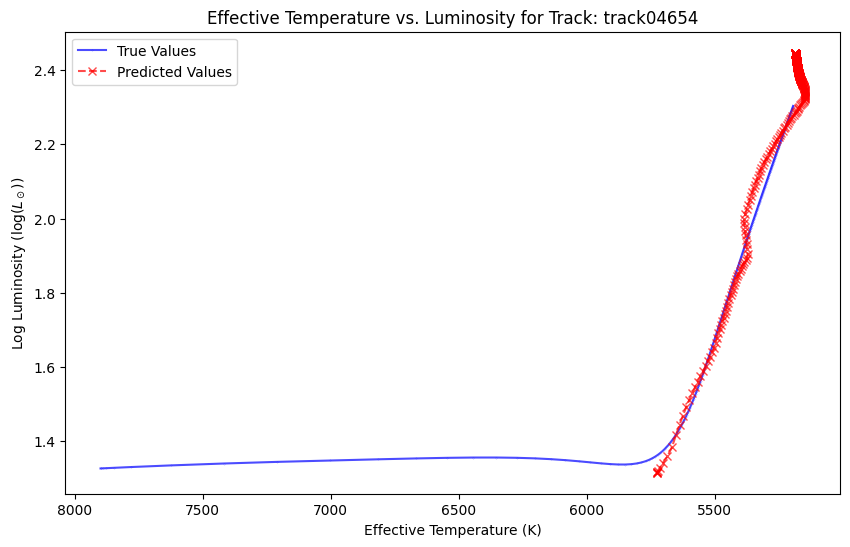

In [ ]:
# Select a random track
specific_track_name = selected_tracks[random.randint(0, len(selected_tracks) - 1)]  

# Retrieve all required inputs for the specific track
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]
    ages = specific_track['age'][:].reshape(-1, 1)
    massini = specific_track['massini'][:].reshape(-1, 1)
    fehini = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini = specific_track['yini'][:].reshape(-1, 1)
    eta = specific_track['eta'][:].reshape(-1, 1)
    alphafe = specific_track['alphaFe'][:].reshape(-1, 1)

    # Combine features into a single array
    all_features = np.hstack((ages, massini, fehini, alphamlt, yini, eta, alphafe))

    # Retrieve actual values for plotting
    teff_specific = specific_track['Teff'][:]
    luminosity_specific = specific_track['LPhot'][:]

# Scale the input features
all_features_scaled = scaler_X.transform(all_features)

# Convert to PyTorch tensor
all_features_tensor = torch.FloatTensor(all_features_scaled)

# Make predictions for the track
model.eval()
with torch.no_grad():
    predictions_specific = model(all_features_tensor).numpy()
    predictions_specific = scaler_y.inverse_transform(predictions_specific)

# Extract predictions and actual values
predicted_teff = predictions_specific[:, 0]
predicted_luminosity = predictions_specific[:, 1]
log_predicted_luminosity = np.log10(predicted_luminosity)

log_actual_luminosity = np.log10(luminosity_specific)

# Plot HR diagram for the specific track
plt.figure(figsize=(10, 6))
plt.plot(teff_specific, log_actual_luminosity, label='True Values', color='blue', alpha=0.7, marker='o', markersize=0.1)
plt.plot(predicted_teff, log_predicted_luminosity, label='Predicted Values', color='red', linestyle='--', alpha=0.7, marker='x')
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Effective Temperature (K)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"Effective Temperature vs. Luminosity for Track: {specific_track_name}")
plt.legend()
plt.show()

